# SCRAPING NEWS HEADLINES and S&P500 DATA

### News Headline Scrape

In [1]:
from newsdataapi import NewsDataApiClient
import pandas as pd
import os
import time
from datetime import datetime, timedelta
from pytz import timezone

# Initialize API
api = NewsDataApiClient(apikey=os.getenv("NEWSDATA_API_KEY"))

# Defining Categories
categories = ["business", "politics"]
all_articles = []

# Path to master CSV
file_path = "news_headlines_master.csv"

# Load existing data (for deduplication)
if os.path.exists(file_path):
    existing_df = pd.read_csv(file_path)
    existing_links = set(existing_df["link"])
else:
    existing_df = pd.DataFrame()
    existing_links = set()

# Loop through each category and scrape the latest headlines
for category in categories:
    print(f"Fetching {category} headlines...")
    try:
        response = api.news_api(
            category=category,
            language="en",
            country="us",
            max_result=100,
            scroll=True
        )
        results = response.get("results", [])
        for article in results:
            link = article.get("link")
            if link and link not in existing_links:
                all_articles.append({
                    "pubDate":     article.get("pubDate"),
                    "title":       article.get("title"),
                    "description": article.get("description"),
                    "source":      article.get("source_id"),
                    "link":        link,
                    "category":    category
                })
    except Exception as e:
        print(f"Error fetching {category}: {e}")
    time.sleep(1)

# Convert to DataFrame
new_df = pd.DataFrame(all_articles)

# Append new articles to the master file
if not new_df.empty:
    final_df = pd.concat([existing_df, new_df], ignore_index=True)
    final_df.to_csv(file_path, index=False)
    print(f"Added {len(new_df)} new articles to '{file_path}'")
else:
    print("No new articles found. Nothing added today.")


Fetching business headlines...


/tmp/ipykernel_2135/1859531550.py:30: DeprecationWarning: This method is deprecated and will be removed in upcoming updates, Instead use latest_api()
  response = api.news_api(


Fetching politics headlines...


Added 200 new articles to 'news_headlines_master.csv'


### SP 500 Scrape

In [2]:
import yfinance as yf
import pandas as pd

# Set the backfill window manually
start_date = "2025-06-25"
end_date = "2025-07-30"  # yfinance excludes end date, so go 1 day beyond

# Download full daily stock data for both days
data = yf.download("^GSPC", start=start_date, end=end_date)

# Format and rename
data = data.reset_index()
data.rename(columns={
    "Date": "date",
    "Open": "open_price",
    "High": "high_price",
    "Low": "low_price",
    "Close": "close_price",
    "Adj Close": "adj_close",
    "Volume": "volume"
}, inplace=True)

# Save it for review
data.to_csv("sp500_full_MASTER.csv", index=False)

print("done")
print(data)

/tmp/ipykernel_2135/2101645649.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^GSPC", start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed

done
Price        date  close_price   high_price    low_price   open_price  \
Ticker                   ^GSPC        ^GSPC        ^GSPC        ^GSPC   
0      2025-06-25  6092.160156  6108.509766  6080.089844  6104.229980   
1      2025-06-26  6141.020020  6146.520020  6107.270020  6112.089844   
2      2025-06-27  6173.069824  6187.680176  6132.350098  6150.700195   
3      2025-06-30  6204.950195  6215.080078  6174.970215  6193.359863   
4      2025-07-01  6198.009766  6210.779785  6177.970215  6187.250000   
5      2025-07-02  6227.419922  6227.600098  6188.290039  6193.879883   
6      2025-07-03  6279.350098  6284.649902  6246.459961  6246.459961   
7      2025-07-07  6229.979980  6262.069824  6201.000000  6259.040039   
8      2025-07-08  6225.520020  6242.700195  6217.750000  6234.029785   
9      2025-07-09  6263.259766  6269.160156  6231.430176  6243.330078   
10     2025-07-10  6280.459961  6290.220215  6251.439941  6266.799805   
11     2025-07-11  6259.750000  6269.439941  6

## DATA PREPROCESSING

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path 
from csv import QUOTE_ALL

#### News Heaadlines

In [4]:
news_df = pd.read_csv("news_headlines_master.csv")
news_df.head(3)

,pubDate,title,description,source,link,category,scrape_date
0,2025-06-25 10:00:00,"IgniteX Sponsors Taiwan Blockchain Hackathon, ...","VICTORIA, Seychelles, June 25, 2025 (GLOBE NEW...",benzinga,https://www.benzinga.com/pressreleases/25/06/g...,business,NaN
1,2025-06-25 10:00:00,Is the 30% Rule Unattainable in 2025? Typical ...,"Pittsburgh, Detroit, and St. Louis are the onl...",benzinga,https://www.benzinga.com/pressreleases/25/06/n...,business,NaN
2,2025-06-25 10:00:00,$6.5B RFG Advisory Launches Suite of Active ETFs,NaN,yahoo,https://finance.yahoo.com/news/6-5b-rfg-adviso...,business,NaN


In [5]:
#cleaning News Headline Data

import re
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

#loading data
news_df = pd.read_csv("news_headlines_master.csv")

#Converting pubDate to datetime
news_df['pubDate'] = pd.to_datetime(news_df['pubDate'], errors='coerce')
news_df['date'] = pd.to_datetime(news_df['pubDate']).dt.strftime('%Y-%m-%d')
news_df = news_df.dropna(subset=['date'])

#Handling with duplicated/missing values
news_df = news_df.drop_duplicates().dropna(subset=['title'])

lemmatizer = WordNetLemmatizer()

#cleaning headlines
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    words = text.strip().split()
    lemmatized = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(lemmatized)

news_df['title_clean'] = news_df['title'].apply(clean_text)

#Saving to new csv
news_df.to_csv("news_cleaned.csv", index=False, quoting=QUOTE_ALL, encoding='utf-8')
print("done")


[nltk_data] Downloading package wordnet to /home/runner/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/runner/nltk_data...


done


#### S&P 500

In [6]:
sp500_df = pd.read_csv("sp500_full_MASTER.csv")
sp500_df

,date,close_price,high_price,low_price,open_price,volume
0,NaN,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
1,2025-06-25,6092.16015625,6108.509765625,6080.08984375,6104.22998046875,5171110000
2,2025-06-26,6141.02001953125,6146.52001953125,6107.27001953125,6112.08984375,5308140000
3,2025-06-27,6173.06982421875,6187.68017578125,6132.35009765625,6150.7001953125,7889350000
4,2025-06-30,6204.9501953125,6215.080078125,6174.97021484375,6193.35986328125,5782900000
5,2025-07-01,6198.009765625,6210.77978515625,6177.97021484375,6187.25,6275310000
6,2025-07-02,6227.419921875,6227.60009765625,6188.2900390625,6193.8798828125,5645710000
7,2025-07-03,6279.35009765625,6284.64990234375,6246.4599609375,6246.4599609375,3378110000
8,2025-07-07,6229.97998046875,6262.06982421875,6201.0,6259.0400390625,5236740000
9,2025-07-08,6225.52001953125,6242.7001953125,6217.75,6234.02978515625,5739030000


In [7]:
#SP 500 Data Cleaning

import pandas as pd  
import numpy as np   

#load data
sp500_df = pd.read_csv("sp500_full_MASTER.csv")  

sp500_df = sp500_df[sp500_df['date'] != 'date'].copy()

#numeric values
cols_to_convert = ['close_price', 'high_price', 'low_price', 'open_price', 'volume']
for col in cols_to_convert:
    sp500_df[col] = pd.to_numeric(sp500_df[col], errors='coerce')

#converting date 
sp500_df['date'] = pd.to_datetime(sp500_df['date'], errors='coerce')
sp500_df = sp500_df.dropna(subset=['date']).sort_values('date').reset_index(drop=True)

sp500_df['daily_return'] = sp500_df['close_price'].pct_change()

#labeling market movement (1 market up, -1 market down, 0 no changes)
sp500_df['label'] = np.where(
    sp500_df['daily_return'] > 0, 1,       
    np.where(sp500_df['daily_return'] < 0, -1, 0))  # no change: retained logic as correct

#saving to csv file 
sp500_df.to_csv("sp500_cleaned.csv", index=False)
print("done")


done


### Merging Data

In [8]:
import pandas as pd
import numpy as np

news_df = pd.read_csv("news_cleaned.csv")
sp500_df = pd.read_csv("sp500_cleaned.csv")

#converting dates
news_df['date'] = pd.to_datetime(news_df['date'])
sp500_df['date'] = pd.to_datetime(sp500_df['date'])

#sorted list of trading days
trading_days_sorted = sorted(set(sp500_df['date']))

#finding the next available trading day
def get_next_trading_day(news_date):
    for d in trading_days_sorted:
        if d > news_date: 
            return d
    return None

news_df['mapped_date'] = news_df['date'].apply(get_next_trading_day)

#Drop any news with no valid trading day
news_df = news_df.dropna(subset=['mapped_date'])

#grouping headlines by mapped (trading) date
daily_news = news_df.groupby('mapped_date')['title_clean'].apply(lambda texts: ' '.join(texts)).reset_index()
daily_news.columns = ['date', 'daily_headlines']

#keeping all trading days
merged_df = pd.merge(sp500_df, daily_news, on='date', how='left')

#filling missing daily_headlines with empty strings
merged_df['daily_headlines'] = merged_df['daily_headlines'].fillna('')

#save excel
merged_df.to_excel("merged_stock_news.xlsx", index=False)

print("done")


done


# SENTIMENT & EMOTION SCORING

In [9]:
!pip install nltk nrclex

In [10]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
import re

# Make sure you downloaded VADER
nltk.download('vader_lexicon')

# Load your merged dataset
df = pd.read_excel("merged_stock_news.xlsx")

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Clean text helper (optional)
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

#VADER sentiment scores
df['daily_headlines_clean'] = df['daily_headlines'].apply(clean_text)
df['sentiment'] = df['daily_headlines_clean'].apply(sia.polarity_scores)

# Split VADER scores into separate columns
df['sent_pos'] = df['sentiment'].apply(lambda x: x['pos'])
df['sent_neg'] = df['sentiment'].apply(lambda x: x['neg'])
df['sent_neu'] = df['sentiment'].apply(lambda x: x['neu'])
df['sent_compound'] = df['sentiment'].apply(lambda x: x['compound'])
df.drop(columns=['sentiment'], inplace=True)

#NRCLex for emotion scoring
def extract_emotions(text):
    if not text.strip():  # added: skip empty strings
        return {f"emo_{e}": 0 for e in ['fear','anger','anticip','trust','surprise','positive','negative','sadness','disgust','joy']}
    emotion_obj = NRCLex(text)
    emotion_freq = emotion_obj.raw_emotion_scores
    all_emotions = ['fear','anger','anticip','trust','surprise','positive','negative','sadness','disgust','joy']
    return {f"emo_{e}": emotion_freq.get(e, 0) for e in all_emotions}

emotion_df = df['daily_headlines_clean'].apply(extract_emotions).apply(pd.Series)
df = pd.concat([df, emotion_df], axis=1)

#Save updated dataset
df.to_excel("stock_news_tone.xlsx", index=False)

print("done.")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/runner/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


done.


# TOPIC MODELING

#### Load and Clean Data

#### Created another/different csv file for topic analysis than sentiment/emotion analysis. we don't ned stop words here

In [11]:
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

#Load data
df_merged = pd.read_excel("merged_stock_news.xlsx")  

#Clean headlines
lemmatizer = WordNetLemmatizer()
stopwords_list = set(stopwords.words('english'))
custom_stopwords = ["think", "might", "like", "get", "do", "go", "will", "say", "said", "one", "two", "three", "four",
    "last", "second", "even", "already", "actually", "however", "though", "within", "every", "about",
    "thanks", "quite", "mean", "wrong", "also", "check", "really", "using", "kind", "ask", "show", "done",
    "question", "comment", "point", "see", "keep", "way", "much", "thing", "back", "again", "let", "th",
    "time", "year", "mail", "hand", "read", "member", "minute", "huge", "went", "current", "supposed",
    "clear", "given", "including", "recently", "made", "correct", "although", "leave", "started", "sent",
    "whether", "trying", "person", "hope", "accord", "context", "whole", "thank", "quote", "right",
    "talk", "gone", "true", "week", "daily", "serve", "held", "toward", "ensure", "called", "says", "told",
    "may", "know", "want", "need", "use", "based", "reason", "side", "earlier", "asked", "tell", "looking",
    "well", "still", "many", "could", "would", "should", "going", "did", "does", "live", "result", "number", "inc", "llc", "management", "holding", 
    "position", "headquarters", "leader", "official", "make", "day", "despite", "long", "top", "beautiful", "entire", "key", "bring", "hold",
    "wa", "flock", "bird", "duck", "ice", "city", "home", "u", "new",
    "share", "july", "today", "court", "law", "case", "summarybrief", "letter", "etf", "big", "sold",
    "edt", "ha", "ap", "standard", "former", "appears", "workflow", "motor", "june", "news", "return", "remain", "lost", "win",
    "farm", "group", "first", "state", "estee", "lauder", "capital", "food"] 

stopwords_list.update(custom_stopwords)

textlist = df_merged["daily_headlines"].astype(str).str.lower().tolist()  # changed: df → df_merged
cleantext = []
for text in textlist:
    text = re.sub(r"http\S+|www\S+|https\S+|\ [A-Za-z]*\.com", '', text)
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords_list]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    cleantext.append(" ".join(tokens))

df_merged["CleanText"] = cleantext  # changed: df → df_merged
df_merged.to_excel("Cleaned_Topic_Headlines.xlsx", index=False)  # changed: df → df_merged
df_merged[["date", "CleanText"]].head()  # changed: df → df_merged

print("done")



[nltk_data] Downloading package punkt to /home/runner/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/runner/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/runner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


done


#### LDA and Keyword Table

In [12]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np  # <-- added


# Use sklearn's built-in English stopwords instead  <-- added
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)  # <-- changed

# Load dataset
df = pd.read_excel("Cleaned_Topic_Headlines.xlsx")

# Drop NaNs
df = df.dropna(subset=["CleanText"])

# Vectorizer using built-in stopwords
dtm = vectorizer.fit_transform(df["CleanText"])

# LDA Model
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(dtm)

# Get topic keywords
words = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda_model.components_):
    top_words = [words[i] for i in topic.argsort()[-10:][::-1]]
    print(f"Topic {idx+1}: {', '.join(top_words)}")

# Get topic distribution for each document
doc_topic_dist = lda_model.transform(dtm)

# Assign most probable topic to each document
dominant_topics = np.argmax(doc_topic_dist, axis=1)

# Get top keywords for each topic
top_n = 10
topic_keywords = []
for topic in lda_model.components_:
    top_indices = topic.argsort()[-top_n:][::-1]
    top_words = [words[i] for i in top_indices]
    topic_keywords.append(", ".join(top_words))

# Create DataFrame for Tableau with date included  <-- changed
lda_df = pd.DataFrame({
    "date": df["date"],  # <-- added
    "Headline": df["CleanText"],
    "Dominant_Topic": dominant_topics,
    "Topic_Keywords": [topic_keywords[i] for i in dominant_topics]
})

# Save to CSV
lda_df.to_csv("topic_modeling.csv", index=False)  # <-- changed filename


Topic 1: jobless, application, job, aid, report, wealth, layoff, low, fell, education
Topic 2: wealth, sell, poll, supreme, stake, street, recent, approve, ruling, epstein
Topic 3: gaza, death, investment, business, epstein, child, struggle, ally, controversy, shake
Topic 4: advisor, wealth, company, sell, investor, report, vanguard, stake, price, house
Topic 5: sell, tariff, advisor, wealth, investment, street, price, wall, rating, company


#### WORD CLOUD 

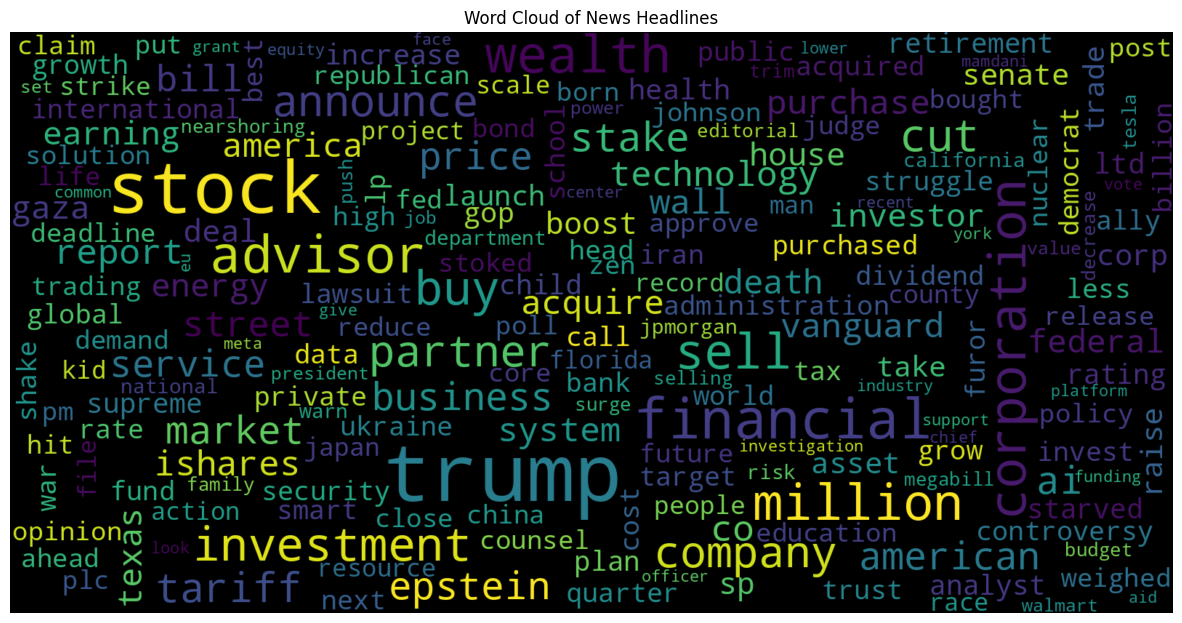

done


In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Combine all cleaned text
consolidated = ' '.join(df_merged["CleanText"])

wordCloud = WordCloud(width=1600, height=800, random_state=21, max_font_size=110, collocations=False).generate(consolidated)

plt.figure(figsize=(15, 10))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of News Headlines")
plt.show()

print("done")

### Topic Analysis for Up and Down Stock

                                            Headline actual_label        date
0  jeff bezos blue origin engaged trump administr...           Up  2025-06-27
1  boot beyonces cowboy carter tour sermon weary ...         Down  2025-06-30
2  londonbased startup laverock therapeutic raise...           Up  2025-07-01
3  esperion appoints craig thompson board directo...           Up  2025-07-02
4  halftime icon take fall injured wnba commissio...         Down  2025-07-03
actual_label
Up      12
Down     7
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to /home/runner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


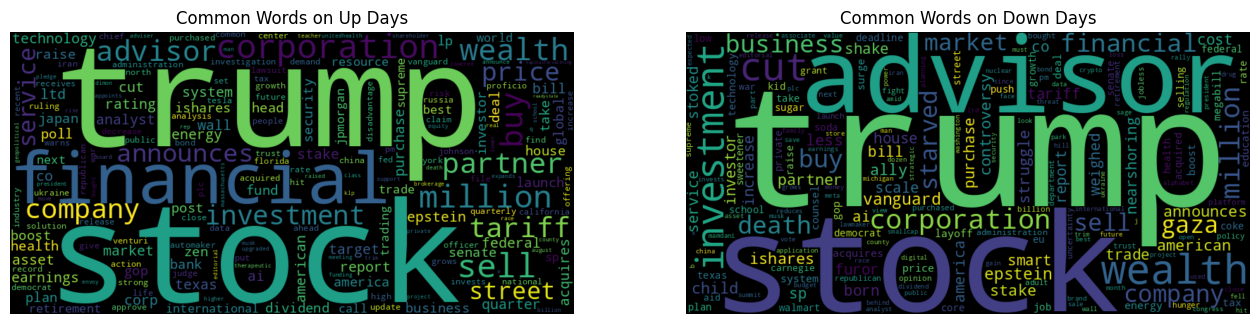

In [14]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

# 1) Load
topic_df      = pd.read_csv("topic_modeling.csv")
prediction_df = pd.read_csv("prediction_results.csv")

# 2) Merge on date
merged_df = pd.merge(topic_df, prediction_df, how="inner", on="date")

# 3) Drop any rows without a label
merged_df = merged_df.dropna(subset=['actual_label'])

# 4) Quick peek to confirm column names & values
print( merged_df[['Headline','actual_label','date']].head() )
print( merged_df['actual_label'].value_counts() )

# 5) Tokenize headlines
merged_df['tokens'] = merged_df['Headline'].str.lower().str.split()

# 6) Explode into word-level series by the string labels
up_words   = merged_df[merged_df['actual_label']=='Up']['tokens'].explode()
down_words = merged_df[merged_df['actual_label']=='Down']['tokens'].explode()

# 7) Count
up_counts   = Counter(up_words)
down_counts = Counter(down_words)

# 8) Remove stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

filtered_up   = {w:c for w,c in up_counts.items()   if w not in stop_words}
filtered_down = {w:c for w,c in down_counts.items() if w not in stop_words}

# 9) Generate & plot word-clouds
up_wc   = WordCloud(width=800, height=400).generate_from_frequencies(filtered_up)
down_wc = WordCloud(width=800, height=400).generate_from_frequencies(filtered_down)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(up_wc,   interpolation='bilinear'); plt.axis('off')
plt.title("Common Words on Up Days")

plt.subplot(1,2,2)
plt.imshow(down_wc, interpolation='bilinear'); plt.axis('off')
plt.title("Common Words on Down Days")

plt.show()

# 10) Export frequencies for Tableau
up_df          = pd.DataFrame(filtered_up.items(),   columns=['word','count'])
up_df['label'] = 'Up'
down_df        = pd.DataFrame(filtered_down.items(), columns=['word','count'])
down_df['label'] = 'Down'

word_freq_df = pd.concat([up_df, down_df], ignore_index=True)
word_freq_df.to_csv("topic_up_down.csv", index=False)


# MACHINE LEARNING

done

 Tomorrow's Prediction:


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

,date,predicted_movement,confidence
22,2025-07-29,Up,0.742742



Last 5 Historical Predictions:


,date,sent_compound,actual_label,predicted_label,prediction_confidence
16,2025-07-22,0.9998,Up,Up,0.633186
17,2025-07-23,0.9996,Up,Down,0.805131
18,2025-07-24,0.9974,Up,Up,0.578578
19,2025-07-25,0.9999,Up,Up,0.508224
20,2025-07-28,-0.9998,Down,Up,0.769469



 Classification Performance:
Accuracy : 52.38%
F1 Score : 0.67
Precision: 0.62
Recall   : 0.71


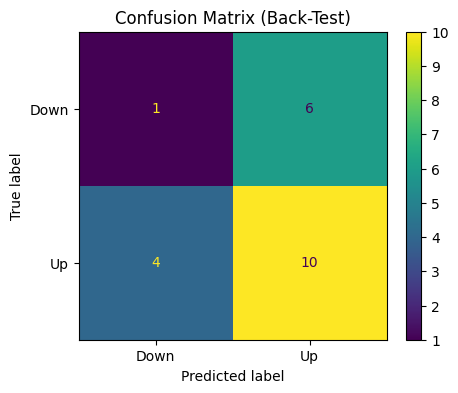

In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Load sentiment and market data
sent = pd.read_excel("stock_news_tone.xlsx")
sp   = pd.read_csv("sp500_cleaned.csv")
sent["date"] = pd.to_datetime(sent["date"])
sp["date"]   = pd.to_datetime(sp["date"])

# Merge and clean
df = (
    pd.merge(sent, sp, on="date", how="inner")
      .rename(columns={"label_y": "label"})
      .query("label != 0")
      .dropna(subset=[
          'sent_pos','sent_neg','sent_neu','sent_compound',
          'emo_fear','emo_anger','emo_anticip','emo_trust',
          'emo_surprise','emo_positive','emo_negative',
          'emo_sadness','emo_disgust','emo_joy'
      ])
      .sort_values("date")
      .reset_index(drop=True)
)

# Shift labels for next-day prediction
df["label_next"] = df["label"].shift(-1)
df = df.dropna(subset=["label_next"]).reset_index(drop=True)
df["label_next"] = df["label_next"].astype(int)

# Feature columns and label map
features = [
    'sent_pos','sent_neg','sent_neu','sent_compound',
    'emo_fear','emo_anger','emo_anticip','emo_trust',
    'emo_surprise','emo_positive','emo_negative',
    'emo_sadness','emo_disgust','emo_joy'
]
label_map = {1: "Up", -1: "Down"}
inverse_label_map = {v: k for k, v in label_map.items()}

# Train final model on all data
scaler_all = StandardScaler().fit(df[features])
model_all = LogisticRegression(max_iter=1000)
model_all.fit(scaler_all.transform(df[features]), df["label_next"])

# Back-test model using historical rolling prediction
history = []
for date in df["date"]:
    train_data = df[df["date"] < date]
    if len(train_data) < 1:
        continue
    if train_data["label_next"].nunique() < 2:
        pred = train_data["label_next"].iloc[0]
        conf = 1.0
    else:
        scaler = StandardScaler().fit(train_data[features])
        model_bt = LogisticRegression(max_iter=1000)
        model_bt.fit(scaler.transform(train_data[features]), train_data["label_next"])
        row = df[df["date"] == date].iloc[0]
        X_row = scaler.transform([row[features]])
        pred = model_bt.predict(X_row)[0]
        conf = model_bt.predict_proba(X_row).max()
    history.append({
        "date": date,
        "sent_compound": df.loc[df["date"] == date, "sent_compound"].iloc[0],
        "actual_label": label_map[df.loc[df["date"] == date, "label_next"].iloc[0]],
        "predicted_label": label_map[pred],
        "prediction_confidence": conf
    })

history_df = pd.DataFrame(history)

# Future predictions for new sentiment dates
last_trade = df["date"].max()
future = sent[~sent["date"].isin(df["date"])].sort_values("date")
future_preds = []
for _, row in future.iterrows():
    X_f = scaler_all.transform([row[features]])
    pred = model_all.predict(X_f)[0]
    conf = model_all.predict_proba(X_f).max()
    future_preds.append({
        "date": row["date"],
        "sent_compound": row["sent_compound"],
        "actual_label": None,
        "predicted_label": label_map[pred],
        "prediction_confidence": conf
    })

future_df = pd.DataFrame(future_preds)

# Combine history + future predictions
combined = pd.concat([history_df, future_df], ignore_index=True)
combined.to_csv("prediction_results.csv", index=False)

# Export tomorrow prediction
tomorrow = combined.iloc[[-1]][["date", "predicted_label", "prediction_confidence"]]
tomorrow.columns = ["date", "predicted_movement", "confidence"]
tomorrow.to_csv("tomorrow_prediction.csv", index=False)


print("done")

from IPython.display import display

print("\n Tomorrow's Prediction:")
display(tomorrow)

print("\nLast 5 Historical Predictions:")
display(history_df.tail())

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# Convert actual and predicted labels to numeric for evaluation
y_true = history_df['actual_label'].map({'Up': 1, 'Down': 0})
y_pred = history_df['predicted_label'].map({'Up': 1, 'Down': 0})

# Calculate metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)

print("\n Classification Performance:")
print(f"Accuracy : {acc:.2%}")
print(f"F1 Score : {f1:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall   : {rec:.2f}")

# Confusion Matrix Plot
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax)
plt.title("Confusion Matrix (Back-Test)")
plt.show()
